<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ЗАДАНИЕ 5.ADALINE, персептрон Розенблатта**

Сгенерируем датасет с двумя классами. В каждом классе будет находиться по $30$ элементов. $x$ и $y$ координаты каждого класса генерируем при помощи нормального распределения с медианами $x: 0.2$ и $0.5$, $y: 0.5$ и дисперсиями $0.05$.

In [ ]:
import numpy as np
import pandas as pd

GROUP_SIZE = 30


"""
Функция generate_array генерирует массив точек заданного размера 
согласно заданным параметрам нормального распределения
"""
def generate_array(m1, d1, m2, d2,  size=GROUP_SIZE):
  return np.concatenate(
    (
      np.random.normal(m1, d1, size=size),
      np.random.normal(m2, d2, size=size)
    )
  )


df = pd.DataFrame(
  {
    'x': generate_array(0.2, 0.05, 0.6, 0.05),
    'y': generate_array(0.5, 0.05, 0.5, 0.05),
    'label': np.array([-1] * GROUP_SIZE + [1] * GROUP_SIZE)
  }
)

X = df[['x', 'y']]
y = df[['label']]

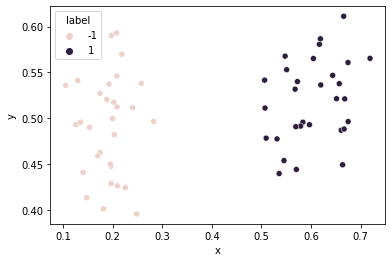

In [ ]:
import seaborn as sns
sns.scatterplot(data=df, x='x', y='y', hue='label')

**Метод стохастического градиента**

Даны $X$ и $Y = \{-1, +1\}$

$a(x, w) = sign (<w,x> - \, w_0) = sign \left(\sum\limits_{j = 1}^n f_j(x) * w_j - w_0\right)$


Смысл метода заключается в том, что сначала выбирается начальное приближение вектора $w$, а затем на каждом шаге он улучшается в направлении наиболее быстрого убывания $Q$.

Алгоритм:

1) Инициализация начального приближения $w$. Например, $random\left(-\frac{1}{2*n}, \frac{1}{2*n}\right)$.

2) $Q = \sum\limits_{i = 1}^l L(<w, x_i> y_i)$

3.1) Выбрать объект $x_i$

3.2) $\varepsilon _i = L(<w, x_i> y_i)$.

3.3) $w = w - \eta L'(<w, x_i> y_i) x_i y_i$.

3.4) $Q = (1 - \lambda) Q + \lambda \varepsilon_i$.

3.5) Повторять шаг 3 пока изменяются $Q$ и/или $w$.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

"""
Класс реализует бинарный линейный классификатор.
Обучается методом стохастического градиента.
"""
class LinearBinaryClassifier:
  """
  Инициализация обучающей выборки.
  В выборку добавляется еще один столбец для подсчетв w0.
  """
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.X['bias'] = np.ones(len(X))
    self.size = len(self.X)
    self.k = len(self.X.iloc[0])
    self.w_history = []


  """
  Метод классифицирует объект.
  Возвращается класс и отступ.
  """
  def predict(self, obj):
    obj = np.append(obj, 1)
    f = np.sum(obj * self.w)
    return np.sign(f), f

  """
  Метод считает сумму потерь по всей выборке
  """
  def calc_loss(self, loss_function):
    loss = 0
    for i in range(self.size):
      x, y = np.dot(self.X.values[i], self.w), self.y.values[i][0]
      loss += loss_function(x, y)
    return loss

  """
  Метод стохастического градиента.
  Детали реализации:
  Параметр break_when_no_errors позволяет остановить обучение при отсутсвии
  ошибок классификации.
  При наличии ошибок классификации объект выбирается по ошибкам, иначе по всей
  выборке.
  Алгоритм останавлиивается после 30000 итераций либо когда Q перестает
  значительно меняться.
  """
  def stochastic_gradient(self, loss_function, update_rule, lmbda, learning_rate, break_when_no_errors=False):
    self.w = np.random.uniform(-1 / (2 * self.k), 1 / (2 * self.k), self.k)
    cur_loss = self.calc_loss(loss_function)
    self.w_history.append(self.w)

    for step in range(1, 30000):
      errors = [i for i in range(self.size) if np.dot(self.X.values[i], self.w) * self.y.values[i][0] < 0]

      if len(errors) == 0 and break_when_no_errors:
        break

      ind = np.random.randint(self.size) if len(errors) == 0 else errors[np.random.randint(len(errors))]
      x = self.X.values[ind]
      y = self.y.values[ind]
      f = np.dot(x, self.w) * y

      eps = loss_function(f, y)
      
      self.w = update_rule(self.w, f, y, x, learning_rate)
      self.w_history.append(self.w)
      
      loss = (1 - lmbda) * cur_loss + lmbda * eps

      if abs(loss - cur_loss) < 0.0001:
        return

      cur_loss = loss


  """
  Метод визуализирует тренировку.
  Рисуются все посчитанные вектора w во вреся обучения.
  Затем рисуются объекты обучающей выборки.
  """
  def visualize_training(self):
    plt.axis([0, 1, 0, 1])
    x = np.linspace(0, 1, 100)
    for [A, B, C] in self.w_history:
      plt.plot(x, (-C - A * x) / B, color="blue", zorder=0)
    
    plt.plot(x, (-self.w[2] - self.w[0] * x) / self.w[1], color="red",
             linewidth=5)

    color = {1: 'green', -1: 'red'}

    for ind in range(len(self.X)):
        plt.scatter(self.X['x'].values[ind], self.X['y'].values[ind],
                  color=color[self.y.values[ind][0]], edgecolors='black',
                  zorder=10)
    
    plt.show()

**Метод ADALINE**

Возьмем $L(M) = (M - 1)^2$.

Для нее $L'(M) = 2(<w, x_i> y_i) x_i$.

Получаем правило обновления весов $w = w - \eta (<w, x_i> y_i) x_i$.

In [ ]:
"""
Класс реализует метод ADALINE.
Наследует класс LinearBinaryClassifier и передаются нужные функция потерь
и правило обновления весов.
"""
class ADALINE(LinearBinaryClassifier):
  def stochastic_gradient(self, lmbda, learning_rate):
    def loss_function(f, y):
      m = f * y
      return (m - 1)**2
    
    def update_rule(w, f, y, x, learning_rate):
      return w - learning_rate * (f - y) * x
    
    return super(ADALINE, self).stochastic_gradient(loss_function, update_rule, lmbda, learning_rate)

Результат работы ADALINE:

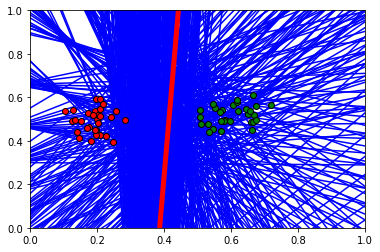

In [ ]:
adaline = ADALINE(X, y)
adaline.stochastic_gradient(0.01, 0.01)
adaline.visualize_training()

**Правило Хэбба**

Этот принцип обучения классификатора основан на принципах нейрофизиологии. Предполагается, что если нейрон угадывает правильный ответ, то его синапсы усиливаются, а если он часто ошибается, или вообще не используется, то синапсы начинают затухать.

Это можно реализовать, если взять $L(M) = (-M)_{+}$.

Правило обновления весов: $if (<w, x_i> y_i) < 0 \, \, \, then \,\, w = w + \eta x_i y_i$.

In [ ]:
"""
Класс реализует метод правило Хэбба.
Наследует класс LinearBinaryClassifier и передаются нужные функция потерь
и правило обновления весов.
"""
class HebbRule(LinearBinaryClassifier):
  def stochastic_gradient(self, lmbda, learning_rate):
    def loss_function(f, y):
      m = f * y
      return max(0, -m)
    
    def update_rule(w, f, y, x, learning_rate):
      return w + learning_rate * x * y
    
    return super(HebbRule, self).stochastic_gradient(loss_function, update_rule, lmbda, learning_rate, True)

Результат работы правила Хэбба:

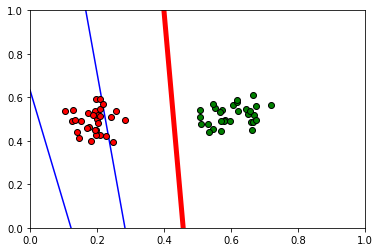

In [ ]:
hebb = HebbRule(X, y)
hebb.stochastic_gradient(0.01, 0.01)
hebb.visualize_training()

**Выводы:**

ADALINE работает дольше, но дает более точную классификацию за счет минимизации $Q$.

Правило Хэбба позволит же быстро провести любую прямую между классами, но это будет давать низкое качество классификации на объектах вне выборки.